In [69]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit, GridSearchCV, 
    train_test_split, cross_validate, cross_val_score
)
from lightgbm import LGBMClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
import re

In [70]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.process_datasets import create_data, get_web_feats

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [71]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans column names: replaces whitespace with underscores,
    removes special characters, and ensures valid Python identifiers.
    """
    new_columns = []
    for col in df.columns:
        # 1. Replace whitespace with underscores
        clean_col = re.sub(r"\s+", "_", col)
        # 2. Remove non-alphanumeric characters except underscore
        clean_col = re.sub(r"[^\w]", "", clean_col)
        # 3. Ensure it doesn't start with a number
        if re.match(r"^\d", clean_col):
            clean_col = "_" + clean_col
        new_columns.append(clean_col)
    df.columns = new_columns
    return df

In [72]:
X_train = pd.read_csv(
    repo_root / "data" / "train" / "churn_labels_with_all_feats.csv"
)
X_test = pd.read_csv(
    repo_root / "data" / "test" / "test_churn_labels_with_all_feats.csv"
)
X_train

,member_id,churn,outreach,total_web_visits,domain_care.portal,domain_example.com,domain_guide.wellness,domain_health.wellco,domain_living.better,domain_media.hub,...,num_repeated_claim_types,repeated_claims_count,days_from_last_claim,has_E11_9,has_I10,has_Z71_3,count_same_claim,app_usage_count,days_from_last_use,days_as_user
0,1,0,0,3,0,0,0,2,0,0,...,2,4,1,1,1,1,4,6,0,459
1,2,0,0,9,3,1,2,2,1,0,...,3,4,2,1,1,1,3,10,0,126
2,3,0,0,52,3,7,10,6,4,5,...,1,1,1,1,0,0,2,9,2,291
3,4,1,0,15,1,3,2,1,3,1,...,1,2,2,0,1,0,3,10,1,455
4,5,0,1,11,2,1,2,0,2,1,...,2,2,1,1,1,1,2,10,1,490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0,18,5,2,4,4,0,1,...,2,3,3,1,0,1,3,8,0,316
9996,9997,0,0,8,0,2,2,2,0,0,...,1,1,1,1,0,1,2,11,1,524
9997,9998,0,0,8,0,1,0,1,2,0,...,5,7,1,0,0,1,4,12,3,317
9998,9999,0,0,36,2,9,4,3,3,4,...,2,3,2,0,0,1,3,7,1,541


In [73]:
# X_train, y_train, X_test, y_test, train, test = create_data(repo_root, config)
# Apply cleaned column names and ensure changes persist on the DataFrames
print(len(X_train.columns))
X_train = clean_column_names(X_train)
print(len(X_train.columns))
X_test = clean_column_names(X_test)
y_train = X_train["churn"].astype(int)
treatment_train = X_train["outreach"].astype(int)

y_test = X_test["churn"].astype(int)
treatment_test = X_test["outreach"].astype(int)

print(f"\nTraining data: {len(X_train)} samples; test data: {len(X_test)} samples")
print(
    f"Treatment in train: {treatment_train.sum()} / {len(treatment_train)} ({100*treatment_train.mean():.1f}%)"
)
print(
    f"Treatment in test: {treatment_test.sum()} / {len(treatment_test)} ({100*treatment_test.mean():.1f}%)"
)

# Choose uplift method (two-model vs meta-learner S-learner)
uplift_method = config.get("uplift_method", "two_model")
models_dir = os.path.join(repo_root, "models")
os.makedirs(models_dir, exist_ok=True)
outputs_dir = os.path.join(repo_root, "outputs")
os.makedirs(outputs_dir, exist_ok=True)
timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

83
83

Training data: 10000 samples; test data: 10000 samples
Treatment in train: 3984 / 10000 (39.8%)
Treatment in test: 3889 / 10000 (38.9%)


In [74]:
X_train.drop(columns=["churn", "outreach", "member_id"], inplace=True)
X_test.drop(columns=["churn", "outreach", "member_id"], inplace=True)
# Scale numeric features (fit on train, apply to test)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Keep column order and index stable when converting back to DataFrame
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_train.head()

,total_web_visits,domain_careportal,domain_examplecom,domain_guidewellness,domain_healthwellco,domain_livingbetter,domain_mediahub,domain_portalsite,domain_worldnews,domain_careportal_days_from_outreach,...,num_repeated_claim_types,repeated_claims_count,days_from_last_claim,has_E11_9,has_I10,has_Z71_3,count_same_claim,app_usage_count,days_from_last_use,days_as_user
0,-1.330597,-1.054848,-1.205246,-1.059017,-0.223147,-1.075078,-1.155771,-0.950133,-1.196385,-0.870243,...,0.559453,1.413648,-0.822732,0.837066,0.835858,0.834305,2.161296,-1.041703,-0.709646,1.040788
1,-0.982486,0.187563,-0.903633,-0.222279,-0.223147,-0.652451,-1.155771,-1.226938,-1.196385,1.093745,...,1.485854,1.413648,-0.343703,0.837066,0.835858,0.834305,0.998309,0.060949,-0.709646,-1.189539
2,1.512311,0.187563,0.906046,3.124673,1.468003,0.615429,0.516932,1.817917,0.643877,0.252036,...,-0.366947,-0.518093,-0.822732,0.837066,-1.196376,-1.198602,-0.164679,-0.214714,0.644252,-0.084422
3,-0.634375,-0.640711,-0.300407,-0.222279,-0.645935,0.192802,-0.821230,-0.396523,-0.889675,0.532605,...,-0.366947,0.125821,-0.343703,-1.194648,0.835858,-1.198602,0.998309,0.060949,-0.032697,1.013997
4,-0.866449,-0.226574,-0.903633,-0.222279,-1.068722,-0.229824,-0.821230,-0.396523,-1.196385,1.093745,...,0.559453,0.125821,-0.822732,0.837066,0.835858,0.834305,-0.164679,0.060949,-0.032697,1.248416


In [75]:
# Diagnostics: ATE, treatment counts, missing values, constant columns
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)
print('\nTreatment counts:')
print('treatment in train:', treatment_train.sum(), '/', len(treatment_train), f'({100*treatment_train.mean():.2f}%)')
print('treatment in test :', treatment_test.sum(), '/', len(treatment_test), f'({100*treatment_test.mean():.2f}%)')

treated_mean_churn = y_train[treatment_train==1].mean()
control_mean_churn = y_train[treatment_train==0].mean()
ate = treated_mean_churn - control_mean_churn
print('\nATE (treated - control):', ate)

print('\nChurn counts (train):')
print(pd.crosstab(treatment_train, y_train))

print('\nTop missing values:')
print(X_train.isna().sum().sort_values(ascending=False).head(20))

numeric = X_train.select_dtypes(include=['number'])
const_cols = numeric.columns[numeric.nunique() <= 1].tolist()
print('\nConstant numeric columns:', const_cols)

print('\nTreatment rate by churn:')
print(treatment_train.groupby(y_train).mean())

print('\nDtypes:')
print(X_train.dtypes.value_counts())

Train shape: (10000, 80)
Test shape: (10000, 80)

Treatment counts:
treatment in train: 3984 / 10000 (39.84%)
treatment in test : 3889 / 10000 (38.89%)

ATE (treated - control): -0.013420704092967611

Churn counts (train):
churn        0     1
outreach            
0         4768  1248
1         3211   773

Top missing values:
total_web_visits                                                    0
domain_careportal                                                   0
category_pets_Dog_training_days_from_outreach                       0
category_nutrition_Mediterranean_diet_days_from_outreach            0
category_nutrition_Cholesterol_friendly_foods_days_from_outreach    0
category_movies_New_releases_days_from_outreach                     0
category_mindfulness_Meditation_guide_days_from_outreach            0
category_hypertension_Lowering_blood_pressure_days_from_outreach    0
category_heart_Hypertension_basics_days_from_outreach               0
category_heart_Cardiometabolic_health_days

---

### 1) Conditional Independence Assumption:

intuition: check if treatment was random

In [76]:
f1_micro = cross_val_score(
    X=X_train,
    y=treatment_train,
    estimator=LGBMClassifier(random_state=42, n_jobs=-1),
    scoring="f1_micro",
    cv=3,
)

print(f'F1 micro {f1_micro.mean():.2f}')

[LightGBM] [Info] Number of positive: 2656, number of negative: 4010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1421
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398440 -> initscore=-0.411970
[LightGBM] [Info] Start training from score -0.411970
[LightGBM] [Info] Number of positive: 2656, number of negative: 4011[LightGBM] [Info] Number of positive: 2656, number of negative: 4011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1421
[LightGBM] [Info] Number of data points in the train set: 6667, number of used features: 80
[LightGBM] [Info] [b

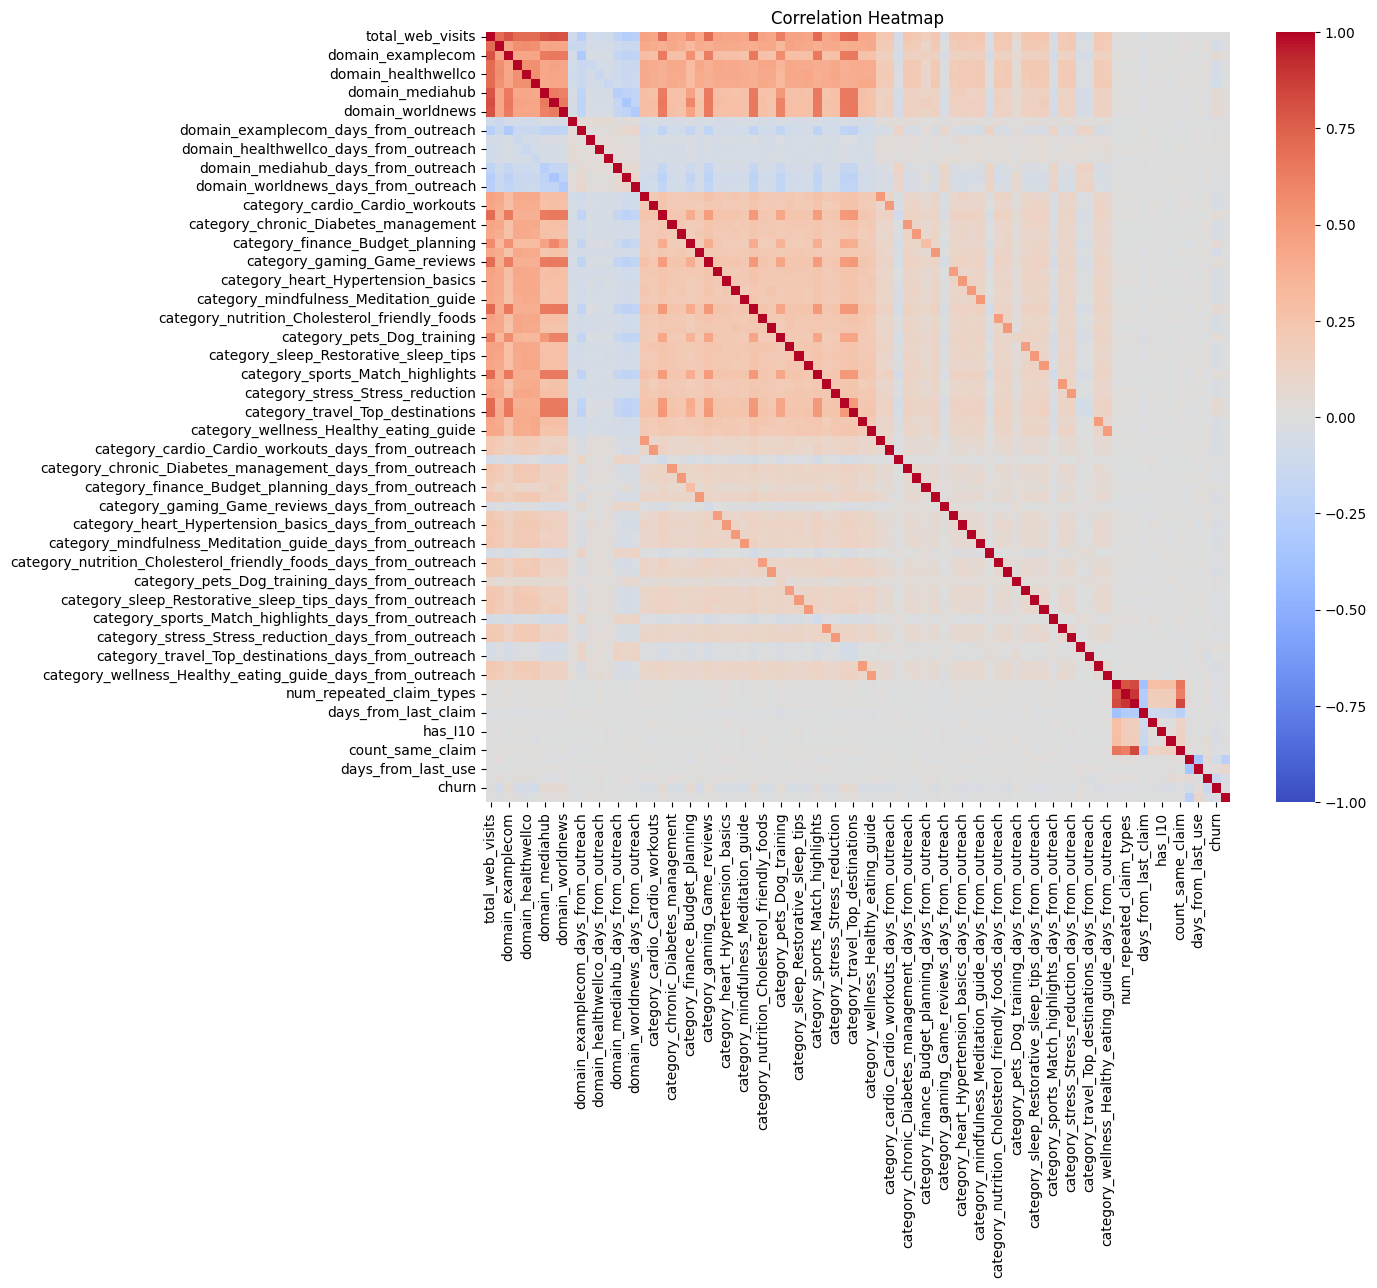

In [77]:
import seaborn as sns

import matplotlib.pyplot as plt

# Combine X_train with churn and outreach
X_train_with_labels = X_train.copy()
X_train_with_labels['churn'] = y_train
X_train_with_labels['outreach'] = treatment_train

# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

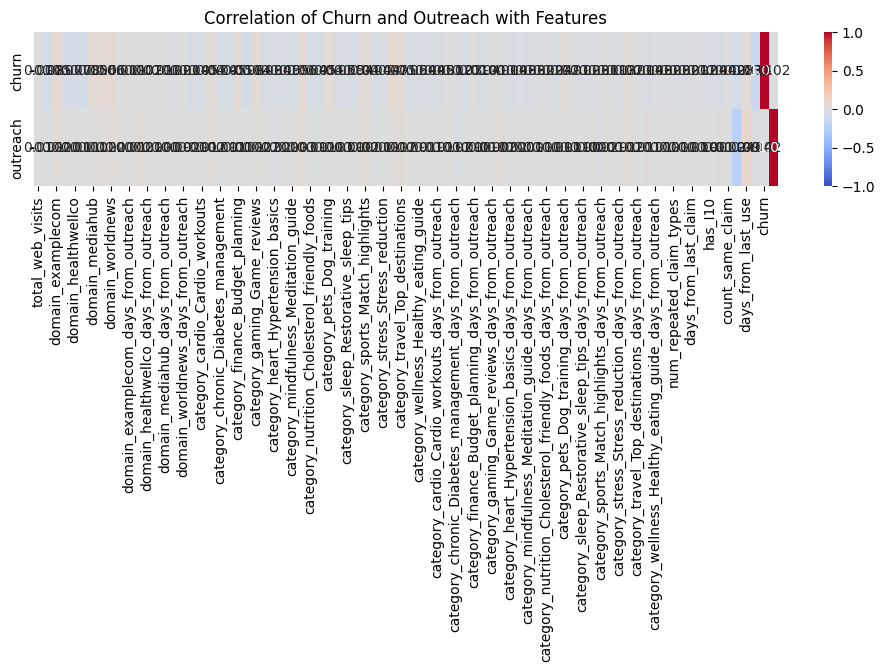

In [78]:
# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Filter the correlation matrix to show only 'churn' and 'outreach' correlations with all features
filtered_corr = corr_matrix.loc[["churn", "outreach"]]

# Display the filtered correlation matrix
plt.figure(figsize=(12, 2))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation of Churn and Outreach with Features")
plt.show()


In [79]:
corr_matrix

,total_web_visits,domain_careportal,domain_examplecom,domain_guidewellness,domain_healthwellco,domain_livingbetter,domain_mediahub,domain_portalsite,domain_worldnews,domain_careportal_days_from_outreach,...,days_from_last_claim,has_E11_9,has_I10,has_Z71_3,count_same_claim,app_usage_count,days_from_last_use,days_as_user,churn,outreach
total_web_visits,1.000000,0.704956,0.803938,0.703438,0.700946,0.698749,0.782827,0.813897,0.795977,-0.099133,...,-0.024962,0.006720,0.006798,-0.004669,0.015090,-0.005281,0.007407,0.008831,0.003213,0.011495
domain_careportal,0.704956,1.000000,0.450458,0.554097,0.556852,0.545097,0.431747,0.444198,0.434234,-0.136614,...,-0.011356,0.007240,0.011381,-0.001490,0.011574,0.025739,-0.004184,0.031531,-0.078038,-0.010713
domain_examplecom,0.803938,0.450458,1.000000,0.440113,0.437147,0.439003,0.634160,0.649172,0.640358,-0.064821,...,-0.025260,0.002789,-0.000273,0.006597,0.018544,-0.013859,-0.001594,0.002418,0.053709,0.022606
domain_guidewellness,0.703438,0.554097,0.440113,1.000000,0.542969,0.551762,0.424428,0.451752,0.443642,-0.084589,...,-0.030023,0.000591,0.017110,0.000719,0.013657,0.007608,0.008564,0.024791,-0.065611,0.000111
domain_healthwellco,0.700946,0.556852,0.437147,0.542969,1.000000,0.554356,0.434496,0.445173,0.431126,-0.095654,...,-0.017153,0.003310,0.005142,-0.001797,0.013405,0.013123,0.001805,0.022309,-0.069455,-0.013365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
app_usage_count,-0.005281,0.025739,-0.013859,0.007608,0.013123,0.010827,-0.011762,-0.020867,-0.021937,-0.004023,...,-0.019208,0.008853,-0.015539,0.013876,0.026868,1.000000,-0.345251,0.060604,-0.078680,-0.237625
days_from_last_use,0.007407,-0.004184,-0.001594,0.008564,0.001805,0.008593,0.011354,0.010252,0.008284,-0.000876,...,0.008284,0.000275,-0.006375,0.011040,-0.001369,-0.345251,1.000000,-0.008024,0.034623,0.087884
days_as_user,0.008831,0.031531,0.002418,0.024791,0.022309,0.014110,-0.008177,-0.016035,0.001542,-0.010067,...,-0.010121,0.012355,0.000519,0.051460,0.034591,0.060604,-0.008024,1.000000,-0.137206,-0.038543
churn,0.003213,-0.078038,0.053709,-0.065611,-0.069455,-0.079146,0.053722,0.060516,0.059780,-0.010727,...,-0.009313,-0.022438,-0.038848,-0.041806,-0.017427,-0.078680,0.034623,-0.137206,1.000000,-0.016362


In [80]:
train_data_outreach_grouped = X_train.groupby(treatment_train).mean()
train_data_outreach_grouped

,total_web_visits,domain_careportal,domain_examplecom,domain_guidewellness,domain_healthwellco,domain_livingbetter,domain_mediahub,domain_portalsite,domain_worldnews,domain_careportal_days_from_outreach,...,num_repeated_claim_types,repeated_claims_count,days_from_last_claim,has_E11_9,has_I10,has_Z71_3,count_same_claim,app_usage_count,days_from_last_use,days_as_user
outreach,,,,,,,,,,,,,,,,,,,,,
0,-0.009354,0.008718,-0.018396,-0.000090,0.010876,0.005725,-0.011182,-0.017067,-0.020016,-0.000039,...,-0.007690,-0.003048,0.004262,0.003577,0.002155,-0.008459,0.001573,0.193374,-0.071518,0.031365
1,0.014125,-0.013165,0.027779,0.000137,-0.016423,-0.008646,0.016885,0.025771,0.030225,0.000058,...,0.011612,0.004602,-0.006435,-0.005402,-0.003255,0.012774,-0.002375,-0.292002,0.107995,-0.047363


In [ ]:
train_data_outreach_grouped = X_train.groupby(treatment_train).mean()
test_data_outreach_grouped = X_test.groupby(treatment_test).mean()

# Calculate the absolute difference between outreach=0 and outreach=1 for each column
column_diffs_train = (
    train_data_outreach_grouped.loc[0] - train_data_outreach_grouped.loc[1]
).abs()
column_diffs_test = (
    test_data_outreach_grouped.loc[0] - test_data_outreach_grouped.loc[1]
).abs()

# Sort the columns by the calculated differences in descending order
sorted_columns_train = column_diffs_train.sort_values(ascending=False)
sorted_columns_test = column_diffs_test.sort_values(ascending=False)

# Display the sorted columns
print(sorted_columns_train[0:10])
print("----")
print(sorted_columns_test[0:10])

app_usage_count                                             0.485376
days_from_last_use                                          0.179512
days_as_user                                                0.078729
category_movies_New_releases                                0.053968
domain_worldnews                                            0.050242
category_travel_Top_destinations                            0.049922
category_sports_Match_highlights                            0.049507
category_heart_Cardiometabolic_health_days_from_outreach    0.047506
domain_examplecom                                           0.046176
category_heart_Hypertension_basics_days_from_outreach       0.043875
dtype: float64
----
app_usage_count                                              0.506309
days_from_last_use                                           0.182994
days_as_user                                                 0.096642
category_recipes_Highfiber_meals_days_from_outreach          0.064351
category_w

In [82]:
train_data_churn_grouped = X_train.groupby(y_train).mean()
test_data_churn_grouped = X_test.groupby(y_test).mean()

# Calculate the absolute difference between outreach=0 and outreach=1 for each column
column_diffs_train = (
    train_data_churn_grouped.loc[0] - train_data_churn_grouped.loc[1]
)
column_diffs_test = (
    test_data_churn_grouped.loc[0] - test_data_churn_grouped.loc[1]
)

# Sort the columns by the calculated differences in descending order
sorted_columns_train = column_diffs_train.sort_values(ascending=False)
sorted_columns_test = column_diffs_test.sort_values(ascending=False)

# Display the sorted columns
print(sorted_columns_train)
print("----")
print(sorted_columns_test)

days_as_user                        0.341676
domain_livingbetter                 0.197093
app_usage_count                     0.195933
domain_careportal                   0.194333
domain_healthwellco                 0.172959
                                      ...   
category_finance_Budget_planning   -0.136856
category_movies_New_releases       -0.140263
domain_worldnews                   -0.148868
domain_portalsite                  -0.150700
category_tech_Gadget_roundup       -0.166473
Length: 80, dtype: float64
----
days_as_user                    0.372546
domain_livingbetter             0.255640
app_usage_count                 0.231448
domain_healthwellco             0.202739
domain_guidewellness            0.196454
                                  ...   
domain_mediahub                -0.087608
category_movies_New_releases   -0.091909
domain_worldnews               -0.095820
domain_examplecom              -0.109714
days_from_last_use             -0.113378
Length: 80, dtype: flo

Based on the user's features, the classifier makes type I and type II errors as often (50%) as it guesses the correct answer. This means that communication was carried out by random.